In [1]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from wmpgnn.datasets.hetero_graph_dataset import CustomHeteroDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add

In [2]:
from wmpgnn.performance.reconstruction import particle_name

In [3]:
from wmpgnn.model.gnn_model import GNN
from wmpgnn.model.model_loader import ModelLoader
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler

In [4]:
config_loader = ConfigLoader("config_files/test_heteromp_gnn_inference.yaml", environment_prefix="DL")#

In [5]:
from wmpgnn.performance.reconstruction import particle_name

In [6]:
from wmpgnn.performance.performance import Performance

In [7]:
perf = Performance(config_loader,cuda=False)

# model_loader = ModelLoader(config_loader)
# model = model_loader.get_model()

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(

In [8]:
config_loader.get("dataset")

{'data_type': 'heterogeneous',
 'data_dir': '/home/sutclw/weighted_MP_gnn/truth_inclusive_10k_49193_xyz'}

In [9]:
config_loader.get("model")

{'type': 'heterognn',
 'gnn_layers': 8,
 'mlp_output_size': 16,
 'mlp_layers': 4,
 'mlp_channels': 128,
 'weight_mlp_layers': 4,
 'weight_mlp_channels': 16,
 'weighted_mp': True,
 'use_edge_weights': True,
 'use_node_weights': True,
 'node_types': ['tracks', 'pvs'],
 'edge_types': ['tracks_tracks', 'tracks_pvs'],
 'norm': 'batch_norm'}

In [8]:
dataset = perf.data_loader.get_test_dataloader(batch_size=1)

In [9]:
model = perf.model

In [ ]:
model.cuda()

In [10]:
cuda = False

In [19]:
perf.set_edge_pruning(layer=0,cut=1e-4,device='cpu')
perf.set_edge_pruning(layer=1,cut=1e-3,device='cpu')
perf.set_edge_pruning(layer=2,cut=1e-2,device='cpu')

In [39]:
#perf.unset_pruning(layer=2)

In [14]:
model = perf.model

In [11]:
#model.cpu()

In [12]:
cuda

False

In [20]:
timing=[]
nparticles=[]
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
for i, vdata in enumerate(dataset):

    #vdata.cuda()
    if i%100 == 0:
        print(i)
    if perf.data_type == "homogeneous":
        vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
        vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
        vdata.senders = vdata.senders - torch.min(vdata.senders)
        vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
        n_tracks = vdata.nodes.shape[0]
    else:
        n_tracks = vdata["tracks"].x.shape[0]
    # start = torch.cuda.Event(enable_timing=True)
    # end = torch.cuda.Event(enable_timing=True)
    if cuda:

        vdata.cuda()
    #torch.cuda.synchronize()
        torch.cuda.synchronize()
        start.record()
        with torch.no_grad():
            gout = model(vdata)
        end.record()
        torch.cuda.synchronize()
        time_model = start.elapsed_time(end)
    else:
        start_time = time.time()
        with torch.no_grad():
            gout = model(vdata)
        end_time = time.time()
        time_model = end_time - start_time
    timing.append(time_model)
    nparticles.append(n_tracks)
    # if i == 400:
    #     break


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [42]:
timing

[0.060476064682006836,
 0.018579721450805664,
 0.020198583602905273,
 0.020694494247436523,
 0.02532052993774414,
 0.02135920524597168,
 0.0235443115234375,
 0.023511171340942383,
 0.0391848087310791,
 0.014087915420532227,
 0.03055286407470703,
 0.03507232666015625,
 0.10186982154846191,
 0.02980780601501465,
 0.09778690338134766,
 0.03696775436401367,
 0.021810293197631836,
 0.018242359161376953,
 0.021794557571411133,
 0.043738365173339844,
 0.039315223693847656,
 0.023815631866455078,
 0.02277374267578125,
 0.037262916564941406,
 0.038642168045043945,
 0.024060487747192383,
 0.06311249732971191,
 0.020104408264160156,
 0.051569461822509766,
 0.032259225845336914,
 0.03332829475402832,
 0.04355597496032715,
 0.03307461738586426,
 0.0310056209564209,
 0.027112722396850586,
 0.035631656646728516,
 0.01218271255493164,
 0.01996302604675293,
 0.018471717834472656,
 0.01360321044921875,
 0.018764257431030273,
 0.017086267471313477,
 0.017263412475585938,
 0.028289794921875,
 0.0302708148

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({"TimeModel":timing, "NumParticlesInEvent" : nparticles}).iloc[1:]

Text(0, 0.5, 'timing ms')

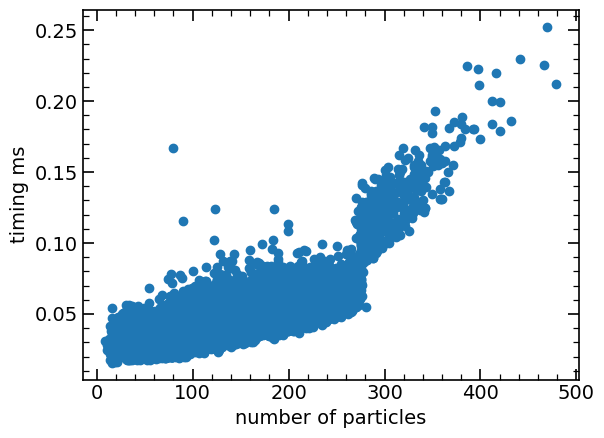

In [25]:
plt.scatter(df.NumParticlesInEvent,df.TimeModel)
plt.xlabel("number of particles")
plt.ylabel("timing ms")

In [35]:
df = pd.read_csv("GNN_CPU_timing_pruned.csv")

In [93]:
df3 = pd.read_csv("HGNN_GPU_timing_pruned.csv")

In [89]:
df2 = pd.read_csv("HGNN_GPU_timing.csv")

In [104]:
df4 = pd.read_csv("GNN_GPU_timing.csv")

In [32]:
#df.to_csv("GNN_CPU_timing.csv")

In [26]:
df.to_csv("HGNN_CPU_timing_pruned.csv")

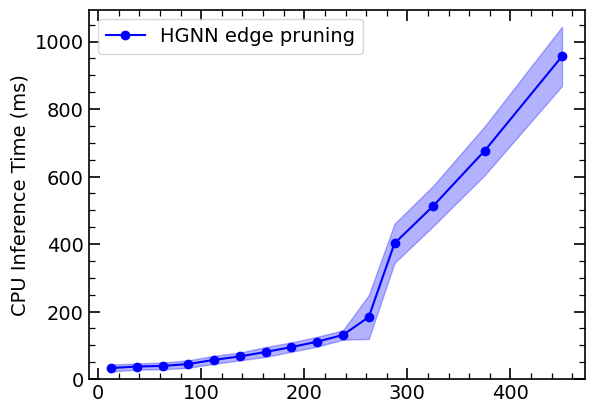

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define your bins and calculate bin centers
bins = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350,400, 500])
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter your DataFrame
#df = df.query("TimeModel < 25")
#df2 = perf.event_df
# Compute mean and standard deviation in each bin
timing = []
std = []
for i in range(len(bins) - 1):
    dfcut = df.query(f"{bins[i]} < NumParticlesInEvent <= {bins[i+1]}")
    # Optionally, check for empty bins to avoid NaN issues:
    if len(dfcut) > 0:
        timing.append(np.mean(dfcut.TimeModel))
        std.append(np.std(dfcut.TimeModel))
    else:
        timing.append(np.nan)
        std.append(np.nan)
timing = np.array(timing)*1000
std = np.array(std)*1000
# Plot the mean line and error band
plt.plot(bin_centers, timing, marker='o', linestyle='-', color='blue', label='HGNN edge pruning')
plt.fill_between(bin_centers, timing - std, timing + std, color='blue', alpha=0.3) # label='± 1 std')
# plt.plot(bin_centers, timing2, marker='o', linestyle='-', color='red', label='HGNN')
# plt.fill_between(bin_centers, timing2 - std2, timing2 + std2, color='red', alpha=0.3)#, label='± 1 std')

# plt.plot(bin_centers, timing3, marker='o', linestyle='-', color='green', label='GNN')
# plt.fill_between(bin_centers, timing3 - std3, timing3 + std3, color='green', alpha=0.3)#, label='± 1 std')
# plt.xlabel('Track multiplicity')
plt.ylabel('CPU Inference Time (ms)')
plt.title('')
plt.legend()
plt.ylim(bottom=0)
plt.show()

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_GNN = pd.read_csv("GNN_GPU_timing.csv").query("(TimeModel < 12 or NumParticlesInEvent > 240)")
df_GNN_pruned = pd.read_csv("GNN_GPU_timing_pruned.csv").query("(TimeModel < 12 or NumParticlesInEvent > 240)and TimeModel < 15")
df_HGNN= pd.read_csv("HGNN_GPU_timing.csv").query("(TimeModel < 15 or NumParticlesInEvent > 240)")
df_HGNN_pruned = pd.read_csv("HGNN_GPU_timing_pruned.csv").query("(TimeModel < 15 or NumParticlesInEvent > 240) and TimeModel < 20")

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Define your bins and calculate bin centers
bins = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350,400, 500])
bin_centers = (bins[:-1] + bins[1:]) / 2

In [108]:
dfs = {"GNN": df_GNN,"GNN edge pruning": df_GNN_pruned, "HGNN": df_HGNN,"HGNN edge pruning": df_HGNN_pruned }
colors = {"GNN": 'red',"GNN edge pruning": 'blue', "HGNN": 'green',"HGNN edge pruning": 'purple'}
linestyles = {"GNN": 'solid',"GNN edge pruning": 'dashed', "HGNN": 'dotted',"HGNN edge pruning": 'dashdot'}

In [109]:
def init_thesis_plot_style():
    my_rc_params = {
        "xtick.direction": "in",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "in",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 2,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 14,
        "axes.grid": False,
        "ytick.right": True,
        "xtick.top": True
    }
    return(my_rc_params)


init_thesis_plot_style()
plt.rcParams.update(init_thesis_plot_style())

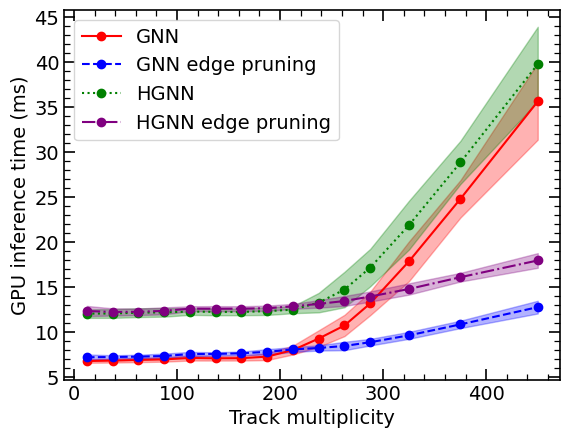

In [110]:
bins = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350,400, 500])
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter your DataFrame
#df = df.query("TimeModel < 25")
#df2 = perf.event_df
# Compute mean and standard deviation in each bin

for key, value in dfs.items():
    timing = []
    std = []
    for i in range(len(bins) - 1):
        dfcut = value.query(f"{bins[i]} < NumParticlesInEvent <= {bins[i+1]}")
        # if len(dfcut) > 0:
        timing.append(np.mean(dfcut.TimeModel))
        std.append(np.std(dfcut.TimeModel))
        # else:
        #     timing.append(np.nan)
        #     std.append(np.nan)
    timing = np.array(timing)
    std = np.array(std)
    plt.xlabel('Track multiplicity')
    plt.ylabel('GPU inference time (ms)')
    plt.plot(bin_centers, timing, marker='o', linestyle=linestyles[key], color=colors[key], label=key)
    plt.fill_between(bin_centers, timing - std, timing + std, color=colors[key], alpha=0.3) 
    plt.legend()
    plt.savefig("GPU_timing.png",dpi=300)
    plt.savefig("GPU_timing.pdf")

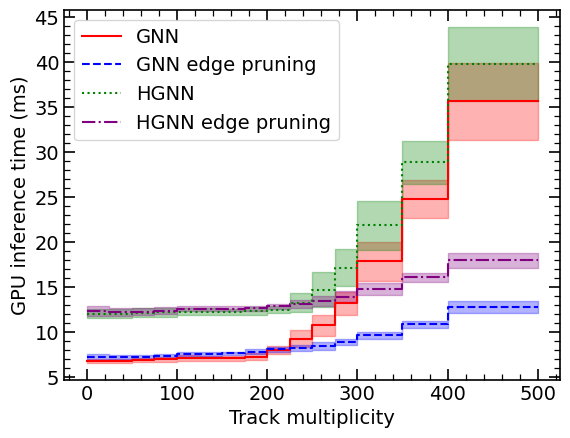

In [111]:
bins = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350,400, 500])
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter your DataFrame
#df = df.query("TimeModel < 25")
#df2 = perf.event_df
# Compute mean and standard deviation in each bin

for key, value in dfs.items():
    timing = []
    std = []
    for i in range(len(bins) - 1):
        dfcut = value.query(f"{bins[i]} < NumParticlesInEvent <= {bins[i+1]}")
        # if len(dfcut) > 0:
        timing.append(np.mean(dfcut.TimeModel))
        std.append(np.std(dfcut.TimeModel))
        # else:
        #     timing.append(np.nan)
        #     std.append(np.nan)
    timing = np.array(timing)
    std = np.array(std)
    plt.xlabel('Track multiplicity')
    plt.ylabel('GPU inference time (ms)')
    x_steps = np.repeat(bins, 2)[1:-1]
    # And the corresponding y-values are the bin values repeated:
    y_steps = np.repeat(timing, 2)
    # Similarly for the error band (lower and upper boundaries):
    lower_steps = np.repeat(timing - std, 2)
    upper_steps = np.repeat(timing + std, 2)
    
    #plt.figure(figsize=(10,6))
    # Plot the histogram-style line
    plt.plot(x_steps, y_steps, drawstyle='steps',  linestyle=linestyles[key], color=colors[key], label=key)
    # Create the error band with a step-like fill
    plt.fill_between(x_steps, lower_steps, upper_steps, step='pre', alpha=0.3, color=colors[key])
    plt.legend()
    plt.savefig("GPU_timing_hist.png",dpi=300)
    plt.savefig("GPU_timing_hist.pdf")

In [112]:
df_GNN = pd.read_csv("GNN_CPU_timing.csv")
df_GNN_pruned = pd.read_csv("GNN_CPU_timing_pruned.csv")
df_HGNN= pd.read_csv("HGNN_CPU_timing.csv")
df_HGNN_pruned = pd.read_csv("HGNN_CPU_timing_pruned.csv")

In [113]:
dfs = {"GNN": df_GNN,"GNN edge pruning": df_GNN_pruned, "HGNN": df_HGNN,"HGNN edge pruning": df_HGNN_pruned }
colors = {"GNN": 'red',"GNN edge pruning": 'blue', "HGNN": 'green',"HGNN edge pruning": 'purple'}
linestyles = {"GNN": 'solid',"GNN edge pruning": 'dashed', "HGNN": 'dotted',"HGNN edge pruning": 'dashdot'}

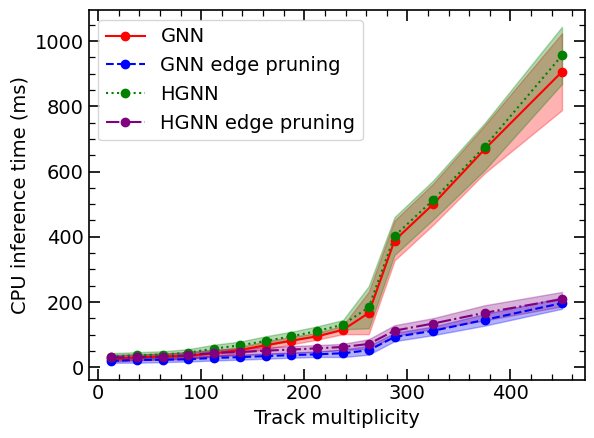

In [100]:
bins = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350,400, 500])
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter your DataFrame
#df = df.query("TimeModel < 25")
#df2 = perf.event_df
# Compute mean and standard deviation in each bin

for key, value in dfs.items():
    timing = []
    std = []
    for i in range(len(bins) - 1):
        dfcut = value.query(f"{bins[i]} < NumParticlesInEvent <= {bins[i+1]}")
        # if len(dfcut) > 0:
        timing.append(np.mean(dfcut.TimeModel))
        std.append(np.std(dfcut.TimeModel))
        # else:
        #     timing.append(np.nan)
        #     std.append(np.nan)
    timing = np.array(timing)*1000
    std = np.array(std)*1000
    plt.xlabel('Track multiplicity')
    plt.ylabel('CPU inference time (ms)')
    plt.plot(bin_centers, timing, marker='o', linestyle=linestyles[key], color=colors[key], label=key)
    plt.fill_between(bin_centers, timing - std, timing + std, color=colors[key], alpha=0.3) 
    plt.legend()
    plt.savefig("CPU_timing.png",dpi=300)
    plt.savefig("CPU_timing.pdf")

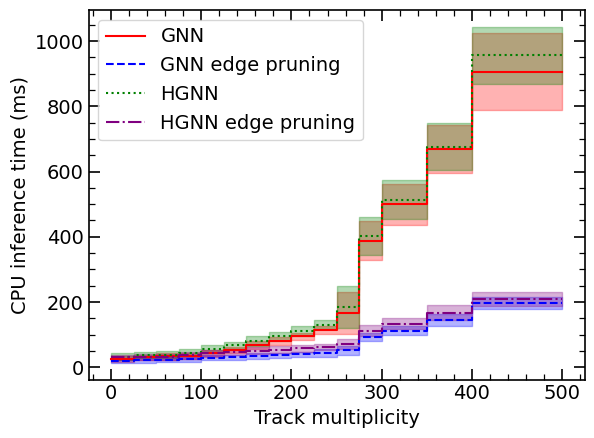

In [105]:
bins = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350,400, 500])
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter your DataFrame
#df = df.query("TimeModel < 25")
#df2 = perf.event_df
# Compute mean and standard deviation in each bin

for key, value in dfs.items():
    timing = []
    std = []
    for i in range(len(bins) - 1):
        dfcut = value.query(f"{bins[i]} < NumParticlesInEvent <= {bins[i+1]}")
        # if len(dfcut) > 0:
        timing.append(np.mean(dfcut.TimeModel))
        std.append(np.std(dfcut.TimeModel))
        # else:
        #     timing.append(np.nan)
        #     std.append(np.nan)
    timing = np.array(timing)*1000
    std = np.array(std)*1000
    plt.xlabel('Track multiplicity')
    plt.ylabel('CPU inference time (ms)')
    #plt.plot(bin_centers, timing, marker='o', linestyle=linestyles[key], color=colors[key], label=key)
    #plt.fill_between(bin_centers, timing - std, timing + std, color=colors[key], alpha=0.3) 
    x_steps = np.repeat(bins, 2)[1:-1]
    # And the corresponding y-values are the bin values repeated:
    y_steps = np.repeat(timing, 2)
    # Similarly for the error band (lower and upper boundaries):
    lower_steps = np.repeat(timing - std, 2)
    upper_steps = np.repeat(timing + std, 2)
    
    #plt.figure(figsize=(10,6))
    # Plot the histogram-style line
    plt.plot(x_steps, y_steps, drawstyle='steps',  linestyle=linestyles[key], color=colors[key], label=key)
    # Create the error band with a step-like fill
    plt.fill_between(x_steps, lower_steps, upper_steps, step='pre', alpha=0.3, color=colors[key])
    plt.legend()
    plt.savefig("CPU_timing_hist.png",dpi=300)

In [ ]:
x_steps = np.repeat(bins, 2)[1:-1]
# And the corresponding y-values are the bin values repeated:
y_steps = np.repeat(timing, 2)
# Similarly for the error band (lower and upper boundaries):
lower_steps = np.repeat(timing - std, 2)
upper_steps = np.repeat(timing + std, 2)

plt.figure(figsize=(10,6))
# Plot the histogram-style line
plt.plot(x_steps, y_steps, drawstyle='steps', color='blue', label='Mean TimeModel')
# Create the error band with a step-like fill
plt.fill_between(x_steps, lower_steps, upper_steps, step='pre', alpha=0.3, color='blue', label='± 1 std')